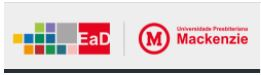

ASSOCIAÇÃO E REGRESSÃO

Profa. Ma.Vanusa da Silva Santana 

TURMA 01A – MATRÍCULA 92104843
Fernando Antonio Carvalho Pessoa

Tarefa da trilha 6: implementar a parte faltante deste código e verificar se o SVR é a técnica mais adequada para predizer a variável ‘SalePrice’ 

Caro aluno, como estamos utilizando várias técnicas de regressão precisamos de um critério de comparação entre os resultados do modelo. Algumas métricas que podem nos ajudar bastante comuns são: MAE (do inglês MEAN ABSOLUTE ERRROR) e o RMSE (do inglês ROOT MEAN SQUARE ERROR) que vamos usar nesse exercício.

Vamos predizer o preço de casas usando técnicas de regressão, para isso vamos utilizar a base de dados do preço de casas de Boston. Vamos nessa?

In [1]:
#Começamos importando as bibliotecas necessárias para visualização dos dados
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import seaborn as sns 
from scipy import stats
from scipy.stats import norm, skew

In [43]:
# carregando o arquivo dados para o Google Colab
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [44]:
# carregando o arquivo dados para o Google Colab
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [45]:
#Leitura dos dados já separados em bases de treinamento e teste
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180921.20 and sigma = 79415.29



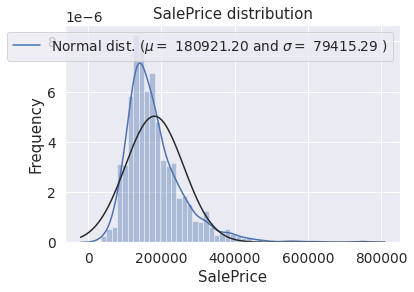

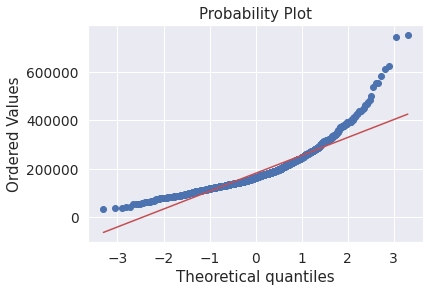

In [46]:
#Vamos dar uma olhada nestes dados
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() 

Observe que os dados não estão corretamente distribuidos. Precisaremos corrigir isso.

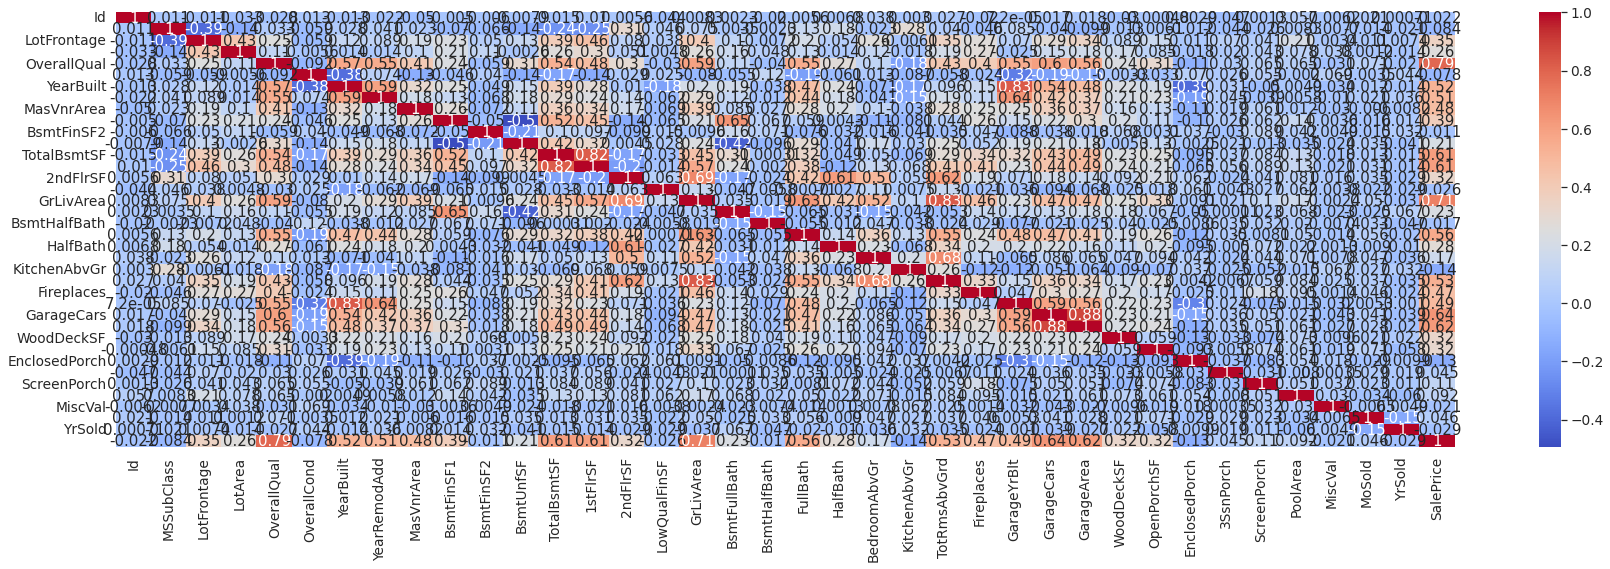

In [47]:
plt.figure(figsize=(30,8))
sns.heatmap(train.corr(),cmap='coolwarm',annot = True)
plt.show()

Com isto podemos verificar os parâmetros com maior correlação com o preço de venda e escolher as features para o nosso modelo de Machine Learning

In [48]:
corr = train.corr()

In [49]:
corr[corr['SalePrice']>0.3].index

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

In [50]:
train = train[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']]
test=test[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF']]

Vamos trabalhar somente com as fetaures que tem uma correlação maior que 0.3 com a feature 'SalePrice' que representa o preço de venda que estamos tentando predizer.

### Feature Engineering

Vamos converter todas as colunas em numéricos ou categóricos

In [51]:
#Missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
2ndFlrSF,0,0.000000
OverallQual,0,0.000000
YearBuilt,0,0.000000
YearRemodAdd,0,0.000000
BsmtFinSF1,0,0.000000
TotalBsmtSF,0,0.000000
1stFlrSF,0,0.000000


Como podemos ver nos parâmetros temos muitos valores faltantes. Por causa disto devemos descartar eles da nossa base de dados. Vamos descartar os parâmetros cujo valor total é maior que 81.

In [52]:
train = train.drop((missing_data[missing_data['Total'] > 81]).index,1)

Faremos o mesmo com os dados de teste.

In [53]:
total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
MasVnrArea,15,0.010281
TotalBsmtSF,1,0.000685
GarageArea,1,0.000685
GarageCars,1,0.000685
BsmtFinSF1,1,0.000685
OverallQual,0,0.000000
YearBuilt,0,0.000000
YearRemodAdd,0,0.000000


In [54]:
test = test.drop((missing_data[missing_data['Total'] > 78]).index,1)

In [55]:
test.isnull().sum().sort_values(ascending=False).head(20)

GarageYrBlt     78
MasVnrArea      15
GarageArea       1
GarageCars       1
BsmtFinSF1       1
TotalBsmtSF      1
OpenPorchSF      0
1stFlrSF         0
YearBuilt        0
YearRemodAdd     0
GrLivArea        0
2ndFlrSF         0
WoodDeckSF       0
FullBath         0
TotRmsAbvGrd     0
Fireplaces       0
OverallQual      0
dtype: int64

In [56]:
train.isnull().sum().sort_values(ascending = False).head(20)

GarageYrBlt     81
MasVnrArea       8
SalePrice        0
2ndFlrSF         0
YearBuilt        0
YearRemodAdd     0
BsmtFinSF1       0
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
OpenPorchSF      0
FullBath         0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OverallQual      0
dtype: int64

Agora vamos tratar os dados faltantes, para isto vamos filtrar os dados categóricos em uma máscara

In [57]:
categorical_feature_mask = train.dtypes==object
categorical_cols = train.columns[categorical_feature_mask].tolist()

In [58]:
categorical_feature_mask_test = test.dtypes==object
categorical_cols_test = test.columns[categorical_feature_mask_test].tolist()

In [59]:
train.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,7,2003,2003,196.0,706,856,856,854,1710,2,8,0,2003.0,2,548,0,61,208500
1,6,1976,1976,0.0,978,1262,1262,0,1262,2,6,1,1976.0,2,460,298,0,181500
2,7,2001,2002,162.0,486,920,920,866,1786,2,6,1,2001.0,2,608,0,42,223500
3,7,1915,1970,0.0,216,756,961,756,1717,1,7,1,1998.0,3,642,0,35,140000
4,8,2000,2000,350.0,655,1145,1145,1053,2198,2,9,1,2000.0,3,836,192,84,250000


In [60]:
test.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,5,1961,1961,0.0,468.0,882.0,896,0,896,1,5,0,1961.0,1.0,730.0,140,0
1,6,1958,1958,108.0,923.0,1329.0,1329,0,1329,1,6,0,1958.0,1.0,312.0,393,36
2,5,1997,1998,0.0,791.0,928.0,928,701,1629,2,6,1,1997.0,2.0,482.0,212,34
3,6,1998,1998,20.0,602.0,926.0,926,678,1604,2,7,1,1998.0,2.0,470.0,360,36
4,8,1992,1992,0.0,263.0,1280.0,1280,0,1280,2,5,0,1992.0,2.0,506.0,0,82


In [61]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())

Com tudo pronto, agora podemos escolher algumas features para nosso modelo. Para isso vamos usar novamente uma matriz de correlação e vamos escolher aquelas que possuem maior correlação com a variável 'SalePrice', ou preço de venda.

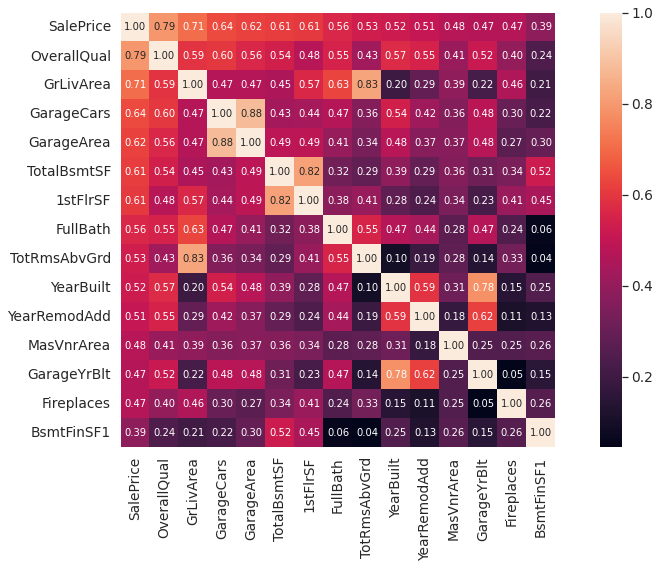

In [62]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = train.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [63]:
train = train[cols]

In [64]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'GarageYrBlt', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')

In [65]:
#Vamos dropar a coluna'SalePrice'da base de teste, já que ela é o alvo da nossa predição.
test=test[cols.drop('SalePrice')]

In [66]:
test.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,GarageYrBlt,Fireplaces,BsmtFinSF1
0,5,896,1.0,730.0,882.0,896,1,5,1961,1961,0.0,1961.0,0,468.0
1,6,1329,1.0,312.0,1329.0,1329,1,6,1958,1958,108.0,1958.0,0,923.0
2,5,1629,2.0,482.0,928.0,928,2,6,1997,1998,0.0,1997.0,1,791.0
3,6,1604,2.0,470.0,926.0,926,2,7,1998,1998,20.0,1998.0,1,602.0
4,8,1280,2.0,506.0,1280.0,1280,2,5,1992,1992,0.0,1992.0,0,263.0


In [67]:
#Por fim, vamos preeencher os valores NULL com a média dos valores.
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'].mean())
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mean())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())

### Regressão 

Com os dados devidamente preparados podemos começar a treinar nossos modelos de regressão. Primeiro precisamos separar nossos dados em um array X que contém as features de treinamento, e um array Y com a feature alvo, neste caso o Preço 'SalePrice'. Vamos aproveitar também para descaratar a coluna 'Address' (Endereço) porque ela contém somente texto e não podemos aproveitar ela em nosso modelo.  

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.3, random_state=101)

In [69]:
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

In [70]:
X_train

array([[ 1.37391375,  2.5236405 ,  0.31454703, ...,  0.46520725,
         0.58626866,  0.07421157],
       [-1.53923947, -0.2856721 ,  0.31454703, ..., -0.54640203,
        -0.97000815, -1.01837681],
       [ 0.64562544, -0.01580724,  0.31454703, ...,  1.2660646 ,
        -0.97000815, -1.01837681],
       ...,
       [-0.08266286,  0.08903234,  0.31454703, ...,  0.04370339,
         0.58626866, -0.83476756],
       [ 0.64562544,  0.03855402,  0.31454703, ...,  1.09746305,
         0.58626866,  1.86950201],
       [-0.81095116, -0.70308897, -1.02489906, ..., -0.84145473,
        -0.97000815,  1.58388762]])

In [72]:
y_train

array([[ 1.51544333],
       [-0.70627462],
       [ 0.64903627],
       ...,
       [-0.38528987],
       [ 0.98676257],
       [-0.61816116]])

In [73]:
#Criando e treinando um modelo de Regressão Linear
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [74]:

lm.fit(X_train,y_train)
print(lm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [75]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

In [76]:
from sklearn import metrics

In [102]:
MAE_RL = metrics.mean_absolute_error(y_test, predictions)
RMSE_RL = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.29105407971784336
RMSE: 0.5476838141164807


In [122]:
#Criando e treinando um modelo de Árvore de Regressão
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=100, splitter='best')

In [79]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [101]:
MAE_AR = metrics.mean_absolute_error(y_test, dtr_pred)
RMSE_AR = np.sqrt(metrics.mean_squared_error(y_test, dtr_pred))
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE: 0.3327904077116327
RMSE: 0.4793729072142496


In [125]:
#Criando e treinando um modelo de SVR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [207]:
#SVR LINEAR
svr = SVR(kernel='linear', C=.2, epsilon=0.1)
svr.fit(X_train,np.ravel(y_train,order="c"))

SVR(C=0.2, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [208]:
svr_pred = svr.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)

In [209]:
MAE_SVL = metrics.mean_absolute_error(y_test, svr_pred)
RMSE_SVL = np.sqrt(metrics.mean_squared_error(y_test, svr_pred))
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))


MAE: 0.28379646876400033
RMSE: 0.5498244216175772


In [204]:
#SRV RBF
svr = SVR(kernel='rbf', C=.2, epsilon=0.1)
svr.fit(X_train,np.ravel(y_train,order="c"))

SVR(C=0.2, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [205]:
svr_pred = svr.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)

In [206]:
MAE_SVR = metrics.mean_absolute_error(y_test, svr_pred)
RMSE_SVR = np.sqrt(metrics.mean_squared_error(y_test, svr_pred))
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

MAE: 0.26489229613424015
RMSE: 0.5265679272319118


# COMPARATIVO

In [215]:
print("                                   SVR LINEAR            REGRESSÃO LINEAR      SVR RBF               ARVORE DE REGRESSÃO ")
print("Erro Médio Absoluto   - MAE       ",MAE_SVL," ",  MAE_RL, " ", MAE_SVR," ", MAE_AR) 
print("Erro Médio Quadrático - RMSE      ", RMSE_SVL,"  ", RMSE_RL, "  ", RMSE_SVR,"  ", RMSE_AR) 

                                   SVR LINEAR            REGRESSÃO LINEAR      SVR RBF               ARVORE DE REGRESSÃO 
Erro Médio Absoluto   - MAE        0.28379646876400033   0.29105407971784336   0.26489229613424015   0.3327904077116327
Erro Médio Quadrático - RMSE       0.5498244216175772    0.5476838141164807    0.5265679272319118    0.4793729072142496


##Comparando os 3 modelos a Regressão linear se sai melhor que o SRV RBF e  a Àrvore de decisão, no entanto ao se utilizar o modelo SRV Linear percebe-se um equilíbrio maior com a regressão linear, superando-a no RMSE mas perdendo no MAE